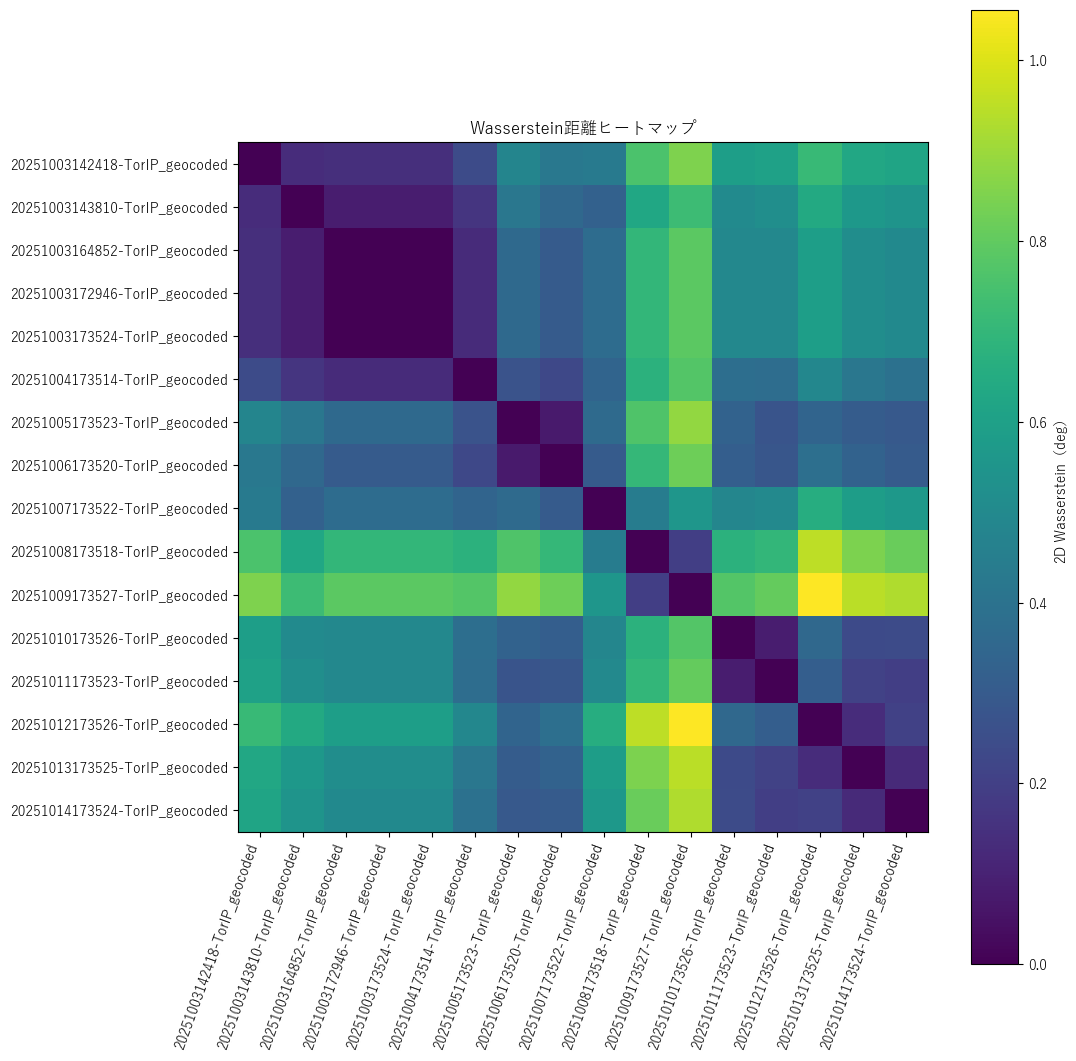

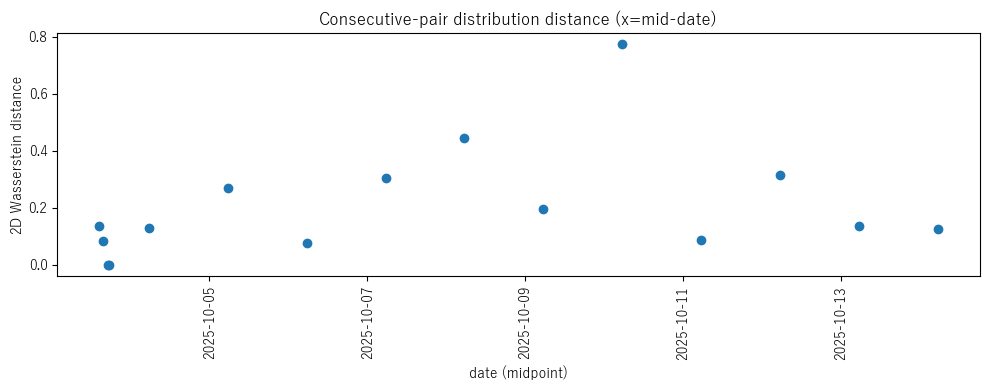

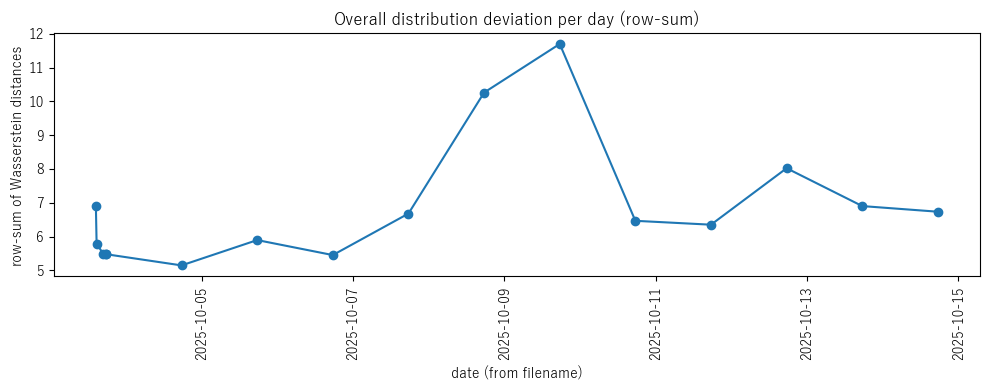

✅ 出力完了（cp932 書き出し）
   wasserstein_matrix.csv
   wasserstein_files.txt
   wasserstein_timeseries.csv
   wasserstein_heatmap.png
   wasserstein_timeseries.png
   wasserstein_row_sums.png


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
isolation_forest.zip を自動解凍して TorIP_geocoded.csv 群を読み込み、
(1) 距離行列 (CSV/PNG) (2) 隣接ペア時系列 (CSV/PNG) (3) 行総和 (PNG) を生成。
— 文字化け対策版（入出力の厳密エンコーディング・正規化・cp932書出し）—
"""

# ========= 設定 =========
ZIP_PATH        = "./isolation_forest.zip"
EXTRACT_DIR     = "./isolation_forest_extracted"
PREFIX          = "wasserstein"
UNIT            = "deg"      # "deg" or "km"
MIN_ROWS        = 1
Z_THR_TS        = 3.5
OUTPUT_ENCODING = "cp932"    # Excel/メモ帳で文字化けしない推奨値（UTF-8で良ければ "utf-8-sig"）
# =======================

import os, sys, csv, math, zipfile, shutil
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib import font_manager, rcParams
from scipy.stats import wasserstein_distance

# ---- 日本語フォント（表示用） ----
JP_FONT_CANDIDATES = ["Yu Gothic", "Meiryo", "Noto Sans CJK JP", "IPAexGothic", "IPAPGothic", "TakaoGothic"]
def setup_japanese_font():
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in JP_FONT_CANDIDATES:
        if name in available:
            rcParams["font.family"] = "sans-serif"
            rcParams["font.sans-serif"] = [name]
            break
    rcParams["axes.unicode_minus"] = False

# ---- 入力エンコ判定フォールバック ----
READ_ENCODINGS = ("utf-8", "utf-8-sig", "cp932", "iso-8859-1")
def open_read_fallback(path):
    last = None
    for enc in READ_ENCODINGS:
        try:
            return open(path, "r", encoding=enc, newline="")
        except Exception as e:
            last = e
    try:
        return open(path, "r", newline="")
    except Exception:
        raise last or RuntimeError(f"cannot open {path}")

# ---- 出力（cp932 等）統一 & 正規化 ----
TRANSLATE_TABLE = {
    0x2010: ord("-"), 0x2011: ord("-"), 0x2012: ord("-"), 0x2013: ord("-"),
    0x2014: ord("-"), 0x2015: ord("-"), 0x2212: ord("-"),
    0x00A0: ord(" "),  # NBSP -> space
}
def normalize_text(s: str) -> str:
    if not isinstance(s, str): return s
    return s.translate(TRANSLATE_TABLE)

def open_write(path):
    # newline="" で CSV の余分な空行を防止、errors="replace" で非対応文字を置換
    return open(path, "w", encoding=OUTPUT_ENCODING, newline="", errors="replace")

# ---- 行ヘッダ判定・CSV読込 ----
def row_has_header_like(cells):
    if len(cells) < 4: return True
    try:
        float((cells[2] or "").strip()); float((cells[3] or "").strip())
        return False
    except Exception:
        return True

def load_valid_latlon(filepath):
    lats, lons = [], []
    with open_read_fallback(filepath) as f:
        rdr = csv.reader(f)
        first = next(rdr, None)
        if first is None:
            return np.empty(0), np.empty(0)
        use_header = row_has_header_like(first)
        rows_iter = rdr if use_header else [first] + list(rdr)
        for row in rows_iter:
            if len(row) < 4: continue
            lat_s = (row[2] or "").strip()
            lon_s = (row[3] or "").strip()
            if not lat_s or not lon_s: continue
            try:
                lat = float(lat_s); lon = float(lon_s)
                if math.isfinite(lat) and math.isfinite(lon):
                    lats.append(lat); lons.append(lon)
            except Exception:
                continue
    return np.array(lats, float), np.array(lons, float)

# ---- 距離計算 ----
def deg_to_km_scale(lat_values):
    phi = (float(np.median(lat_values)) if len(lat_values) else 0.0) * math.pi/180.0
    return 111.32, 111.32 * math.cos(phi)

def composite_wasserstein_2d(lat_a, lon_a, lat_b, lon_b):
    if UNIT == "km":
        la_km, lo_km = deg_to_km_scale(np.concatenate([lat_a, lat_b]))
        lat_a = lat_a * la_km; lat_b = lat_b * la_km
        lon_a = lon_a * lo_km; lon_b = lon_b * lo_km
    d_lat = wasserstein_distance(lat_a, lat_b)
    d_lon = wasserstein_distance(lon_a, lon_b)
    return float(np.hypot(d_lat, d_lon))

def robust_zscore(x: np.ndarray) -> np.ndarray:
    if x.size == 0: return np.zeros(0, float)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    if mad == 0: return np.zeros_like(x, float)
    return 0.6745 * (x - med) / mad

def date_from_filename(fname: str):
    key = os.path.basename(fname).split("-")[0]
    try:
        dt = datetime.strptime(key[:14], "%Y%m%d%H%M%S")
        return dt.date(), dt
    except Exception:
        return None

def main():
    setup_japanese_font()

    # zip 展開
    if os.path.exists(EXTRACT_DIR):
        shutil.rmtree(EXTRACT_DIR)
    os.makedirs(EXTRACT_DIR, exist_ok=True)
    if not os.path.exists(ZIP_PATH):
        print(f"[ERROR] zipが見つかりません: {ZIP_PATH}", file=sys.stderr); return
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(EXTRACT_DIR)

    # 対象CSV収集
    csv_files = []
    for root, _, files in os.walk(EXTRACT_DIR):
        for f in files:
            if f.endswith("TorIP_geocoded.csv"):
                csv_files.append(os.path.join(root, f))
    if len(csv_files) < 2:
        print("[ERROR] 有効CSVが2件未満です。", file=sys.stderr); return

    # 読み込み
    records = []  # (date, dt_full, path, lats, lons)
    for f in sorted(csv_files):
        d = date_from_filename(f)
        if d is None:
            print(f"[WARN] 日付抽出に失敗: {f}", file=sys.stderr); continue
        day, dt_full = d
        lats, lons = load_valid_latlon(f)
        if len(lats) >= MIN_ROWS and len(lons) >= MIN_ROWS:
            records.append((day, dt_full, f, lats, lons))
        else:
            print(f"[WARN] 有効行不足: {f}", file=sys.stderr)

    if len(records) < 2:
        print("[ERROR] 有効データが2件未満です。", file=sys.stderr); return

    # 日時ソート
    records.sort(key=lambda t: t[1])
    base_names = [os.path.splitext(os.path.basename(r[2]))[0] for r in records]
    n = len(records)

    # (1) 距離行列
    dist = np.zeros((n, n), float)
    for i in range(n):
        for j in range(i + 1, n):
            d = composite_wasserstein_2d(records[i][3], records[i][4],
                                         records[j][3], records[j][4])
            dist[i, j] = dist[j, i] = d

    # CSV（cp932）: 文字化け回避のため csv.writer を使用
    matrix_csv = f"{PREFIX}_matrix.csv"
    with open_write(matrix_csv) as w:
        wr = csv.writer(w)
        wr.writerow([""] + [normalize_text(nm) for nm in base_names])
        for i, nm in enumerate(base_names):
            wr.writerow([normalize_text(nm)] + [f"{x:.6f}" for x in dist[i]])

    files_txt = f"{PREFIX}_files.txt"
    with open_write(files_txt) as w:
        w.write("\n".join(normalize_text(nm) for nm in base_names))

    # ヒートマップ
    fig = plt.figure(figsize=(max(6, n * 0.7), max(5, n * 0.7)))
    ax = plt.gca()
    im = ax.imshow(dist, aspect="equal", interpolation="nearest")
    cbar = plt.colorbar(im); cbar.set_label(f"2D Wasserstein（{UNIT}）")
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(base_names, rotation=70, ha="right")
    ax.set_yticklabels(base_names)
    ax.set_title("Wasserstein距離ヒートマップ")
    plt.tight_layout()
    plt.savefig(f"{PREFIX}_heatmap.png", dpi=200, bbox_inches="tight")
    plt.show(); plt.close()

    # (2) 隣接ペア時系列
    dt_full = [r[1] for r in records]
    x_dates, dist_vals, file_pair = [], [], []
    for i in range(1, n):
        d = composite_wasserstein_2d(records[i-1][3], records[i-1][4],
                                     records[i][3],  records[i][4])
        dist_vals.append(d)
        mid = dt_full[i-1] + (dt_full[i] - dt_full[i-1]) / 2
        x_dates.append(mid)
        file_pair.append(f"{base_names[i-1]} -> {base_names[i]}")

    x_dates = np.array(x_dates, dtype=object)
    dist_vals = np.array(dist_vals, float)
    z = robust_zscore(dist_vals)

    ts_csv = f"{PREFIX}_timeseries.csv"
    with open_write(ts_csv) as w:
        wr = csv.writer(w)
        wr.writerow(["date_mid","file_pair","distance","z"])
        for i in range(len(dist_vals)):
            wr.writerow([
                x_dates[i].strftime("%Y-%m-%d %H:%M:%S"),
                normalize_text(file_pair[i]),
                f"{dist_vals[i]:.6f}",
                f"{z[i]:.3f}",
            ])

    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.plot(x_dates, dist_vals, marker="o", linestyle="none")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
    plt.xlabel("date (midpoint)"); plt.ylabel("2D Wasserstein distance")
    plt.title("Consecutive-pair distribution distance (x=mid-date)")
    plt.tight_layout()
    plt.savefig(f"{PREFIX}_timeseries.png", dpi=200, bbox_inches="tight")
    plt.show(); plt.close()

    # (3) 行総和
    row_sums = dist.sum(axis=1)
    dates_sorted = [r[1] for r in records]
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.plot(dates_sorted, row_sums, marker="o")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(ax.xaxis.get_major_locator()))
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
    plt.xlabel("date (from filename)")
    plt.ylabel("row-sum of Wasserstein distances")
    plt.title("Overall distribution deviation per day (row-sum)")
    plt.tight_layout()
    plt.savefig(f"{PREFIX}_row_sums.png", dpi=200, bbox_inches="tight")
    plt.show(); plt.close()

    print("✅ 出力完了（cp932 書き出し）")
    print("  ", matrix_csv)
    print("  ", files_txt)
    print("  ", ts_csv)
    print("  ", f"{PREFIX}_heatmap.png")
    print("  ", f"{PREFIX}_timeseries.png")
    print("  ", f"{PREFIX}_row_sums.png")

if __name__ == "__main__":
    main()
